In [1]:
import os
import numpy as np

import time as time

from functools import partial
from tqdm import tqdm

# Import torch and select GPU
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

# Plot functions
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torchmetrics.functional import structural_similarity_index_measure
from torchmetrics.functional import peak_signal_noise_ratio

# Radio and convex reg functions
import quantifai as qai
from quantifai.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg

True
1
0
NVIDIA A100-PCIE-40GB


## Set hyperparameters 

In [2]:
# Parameters

# Optimisation options for the MAP estimation
options = {"tol": 1e-5, "iter": 15000, "update_iter": 100, "record_iters": False}

# Save param
repo_dir = "./.."

# Test image name from ['M31', 'W28', 'CYN', '3c288']
img_name = "M31"
# Input noise level
input_snr = 30.0

# Define my torch types (CRR requires torch.float32)
myType = torch.float32
myComplexType = torch.complex64

# CRR load parameters
sigma_training = 5
t_model = 5
CRR_dir_name = "./../trained_models/"
# CRR parameters
lmbd = 5e4  # lambda parameter
mu = 20

# Prepare observations 

In [3]:
# Load image and mask
img, mat_mask = qai.helpers.load_imgs(img_name, repo_dir)

# Aliases
x = img
ground_truth = img

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape(
    (1, 1) + img.shape
)

phi = qai.operators.MaskedFourier_torch(
    shape=img.shape, ratio=0.5, mask=mat_mask, norm="ortho", device=device
)

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Define noise level
eff_sigma = qai.helpers.compute_complex_sigma_noise(y, input_snr)
sigma = eff_sigma * np.sqrt(2)

# Generate noise
rng = np.random.default_rng(seed=0)
n_re = rng.normal(0, eff_sigma, y[y != 0].shape)
n_im = rng.normal(0, eff_sigma, y[y != 0].shape)
# Add noise
y[y != 0] += n_re + 1.0j * n_im

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape(
    (1,) + img.shape
)
# Generate first guess
x_init = torch.abs(phi.adj_op(torch_y))

INSTRUME                                                                         [astropy.io.fits.card]


# Define likelihood and prior

In [4]:
# Define the likelihood
likelihood = qai.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
# Lipschitz constant computed automatically by g, stored in g.beta

# Define real prox
prox_op = qai.operators.RealProx_torch()

In [5]:
# Load CRR model
torch.set_grad_enabled(False)
# torch.set_num_threads(4)

exp_name = f"Sigma_{sigma_training}_t_{t_model}/"
if device.type == "cpu":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cpu", device_type="cpu"
    )
elif device.type == "cuda":
    CRR_model = utils_cvx_reg.load_model(
        CRR_dir_name + exp_name, "cuda", device_type="gpu"
    )


print(f"Numbers of parameters before prunning: {CRR_model.num_params}")
CRR_model.prune()
print(f"Numbers of parameters after prunning: {CRR_model.num_params}")

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 - linear_spline activation functions
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
Numbers of parameters before prunning: 13610
---------------------
 PRUNNING 
 Found 22 filters with non-vanishing potential functions
---------------------
Numbers of parameters after prunning: 4183


In [6]:
# [not required] intialize the eigen vector of dimension (size, size) associated to the largest eigen value
CRR_model.initializeEigen(size=100)
# compute bound via a power iteration which couples the activations and the convolutions
L_CRR = CRR_model.precise_lipschitz_bound(n_iter=100)
# the bound is stored in the model
# L_CRR = model.L.data.item()
print(f"Lipschitz bound {L_CRR:.3f}")

Lipschitz bound 0.781


# Run optimisation algorithm anc compute the MAP reconstruction

In [7]:
# Compute stepsize
alpha = 0.98 / (likelihood.beta + mu * lmbd * L_CRR)

x_hat = qai.optim.FISTA_CRR_torch(
    x_init=x_init,
    options=options,
    likelihood=likelihood,
    prox_op=prox_op,
    CRR_model=CRR_model,
    alpha=alpha,
    lmbd=lmbd,
    mu=mu,
)

[GD] 0 out of 15000 iterations, tol = 0.017036


[GD] 100 out of 15000 iterations, tol = 0.002369
[GD] 200 out of 15000 iterations, tol = 0.000743
[GD] 300 out of 15000 iterations, tol = 0.000318
[GD] 400 out of 15000 iterations, tol = 0.000190
[GD] 500 out of 15000 iterations, tol = 0.000064
[GD] 600 out of 15000 iterations, tol = 0.000080
[GD] 700 out of 15000 iterations, tol = 0.000037
[GD] 800 out of 15000 iterations, tol = 0.000038
[GD] 900 out of 15000 iterations, tol = 0.000024
[GD] 1000 out of 15000 iterations, tol = 0.000013
[GD] converged in 1005 iterations


# Plot MAP reconstruction

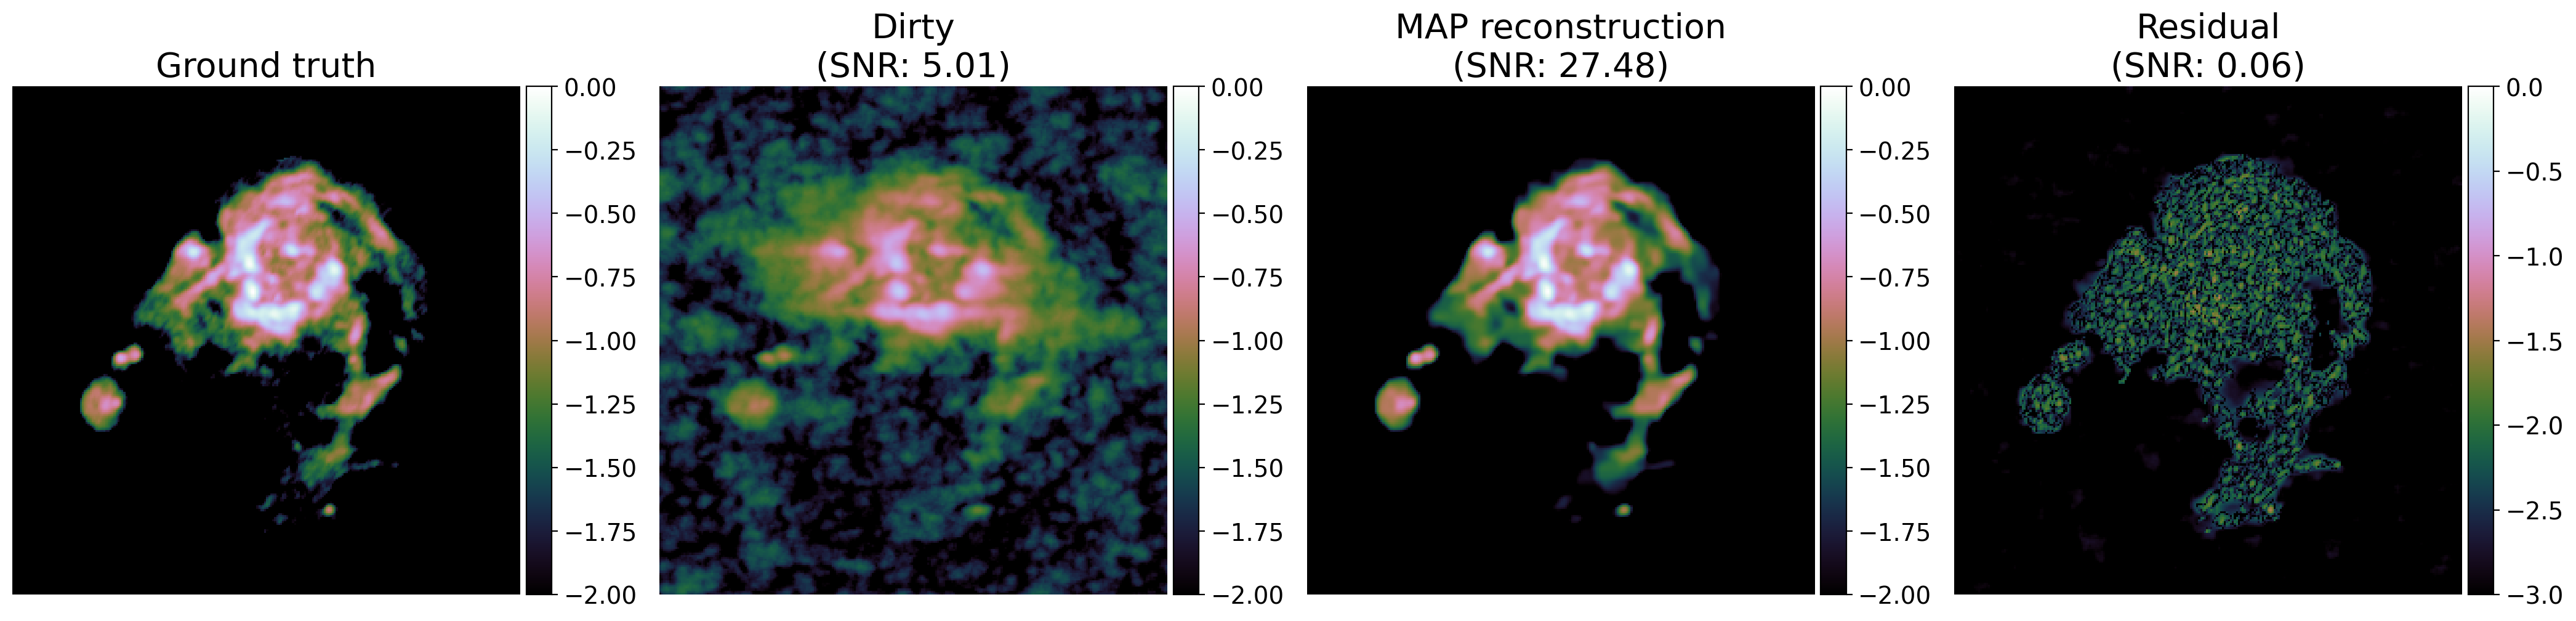

In [8]:
# Convert to numpy
np_x_init = to_numpy(x_init)
x_map = x_hat.clone()
x_gt = np.copy(x)
np_x_gt = np.copy(x)
np_x_map = to_numpy(x_map)


# Need to replace zero values with veery small numbers for the log plots
np_x_gt[np_x_gt == 0] = np.random.rand(np.sum(np_x_gt == 0)) * 1e-7

images = [np_x_gt, np_x_init, np_x_map, np_x_gt - np.abs(np_x_map)]
labels = ["Ground truth", "Dirty", "MAP reconstruction", "Residual"]
vmin_log = [-2.0, -2.0, -2.0, -3.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, 4, figsize=(26, 8), dpi=200)
for i in range(4):
    im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    if i > 0:
        stats_str = "\n(SNR: {})".format(
            round(qai.utils.eval_snr(x, images[i]), 2),
        )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")
plt.show()

# Compute posterior samples using the SK-ROCK sampling algorithm

### Define hyperparameters

In [9]:
# Sampling alg params
frac_delta = 0.98  # Parameter used when computing the chain's step size
frac_burnin = 0.1  # Burnin samples specified as a percentage of the total number of samples, i.e. 0.1 -> 10%
n_samples = np.int64(5e2)  # Number of posterior samples desired
thinning = np.int64(1e1)  # Thinning factor: Number of samples discarded between two saved posterior samples
maxit = np.int64(n_samples * thinning * (1.0 + frac_burnin))

# SKROCK params
nStages = 10 
eta = 0.05
dt_perc = 0.99


### Compute step size and initialisations

In [10]:
# Compute differentiable part Lipschitz constant
Lip_total = mu * lmbd * L_CRR + likelihood.beta

# Step size for chain
delta = frac_delta / Lip_total

# Sampling alg params
burnin = np.int64(n_samples * thinning * frac_burnin)
MC_X = np.zeros((n_samples, x_init.shape[1], x_init.shape[2]))
logpi_thinning_trace = np.zeros((n_samples, 1))
thinned_trace_counter = 0

nrmse_values = []
psnr_values = []
ssim_values = []
logpi_eval = []


### Define function handles

In [11]:
# function handles to used for Langevin sampling
def _fun(_x, CRR_model, mu, lmbd):
    return (lmbd / mu) * CRR_model.cost(mu * _x) + likelihood.fun(_x)

def _grad_fun(_x, likelihood, CRR_model, mu, lmbd):
    return torch.real(likelihood.grad(_x) + lmbd * CRR_model(mu * _x))


# Evaluation of the potentials
fun = partial(_fun, CRR_model=CRR_model, mu=mu, lmbd=lmbd)
# Evaluation of the gradient
grad_f = partial(
    _grad_fun, likelihood=likelihood, CRR_model=CRR_model, mu=mu, lmbd=lmbd
)

### Run the sampling algorithm

In [12]:
X = x_init.clone()

start_time = time.time()
for i_x in tqdm(range(maxit)):
    # Update X
    X = qai.sampling.SKROCK_kernel(
        X,
        Lipschitz_U=Lip_total,
        nStages=nStages,
        eta=eta,
        dt_perc=dt_perc,
        grad_likelihood_prior=grad_f,
    )

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = qai.utils.welford(X)
        absfouriercoeff = qai.utils.welford(torch.fft.fft2(X).abs())
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        psnr_values.append(
            peak_signal_noise_ratio(torch_img, current_mean).item()
        )
        ssim_values.append(
            structural_similarity_index_measure(torch_img, current_mean).item()
        )
        # Need to use pytorch version of NRMSE!
        nrmse_values.append(
            qai.utils.nrmse(torch_img, current_mean)
        )
        logpi_eval.append(fun(X).item())

        # collect thinned trace
        if np.mod(i_x - burnin, thinning) == 0:
            MC_X[thinned_trace_counter] = X.detach().cpu().numpy()
            logpi_thinning_trace[thinned_trace_counter] = fun(X).item()
            thinned_trace_counter += 1

end_time = time.time()
elapsed = end_time - start_time

current_mean = post_meanvar.get_mean().detach().cpu().squeeze()
current_var = post_meanvar.get_var().detach().cpu().squeeze()



  1%|          | 55/5500 [00:00<00:53, 102.25it/s]

  9%|▉         | 516/5500 [00:05<00:54, 90.91it/s] 

-----------------------
Updating spline coefficients for the reg cost
 (the gradient-step model is trained and intergration is required to compute the regularization cost)
-----------------------


100%|██████████| 5500/5500 [01:05<00:00, 83.91it/s]


### Plot posterior mean and standard deviation

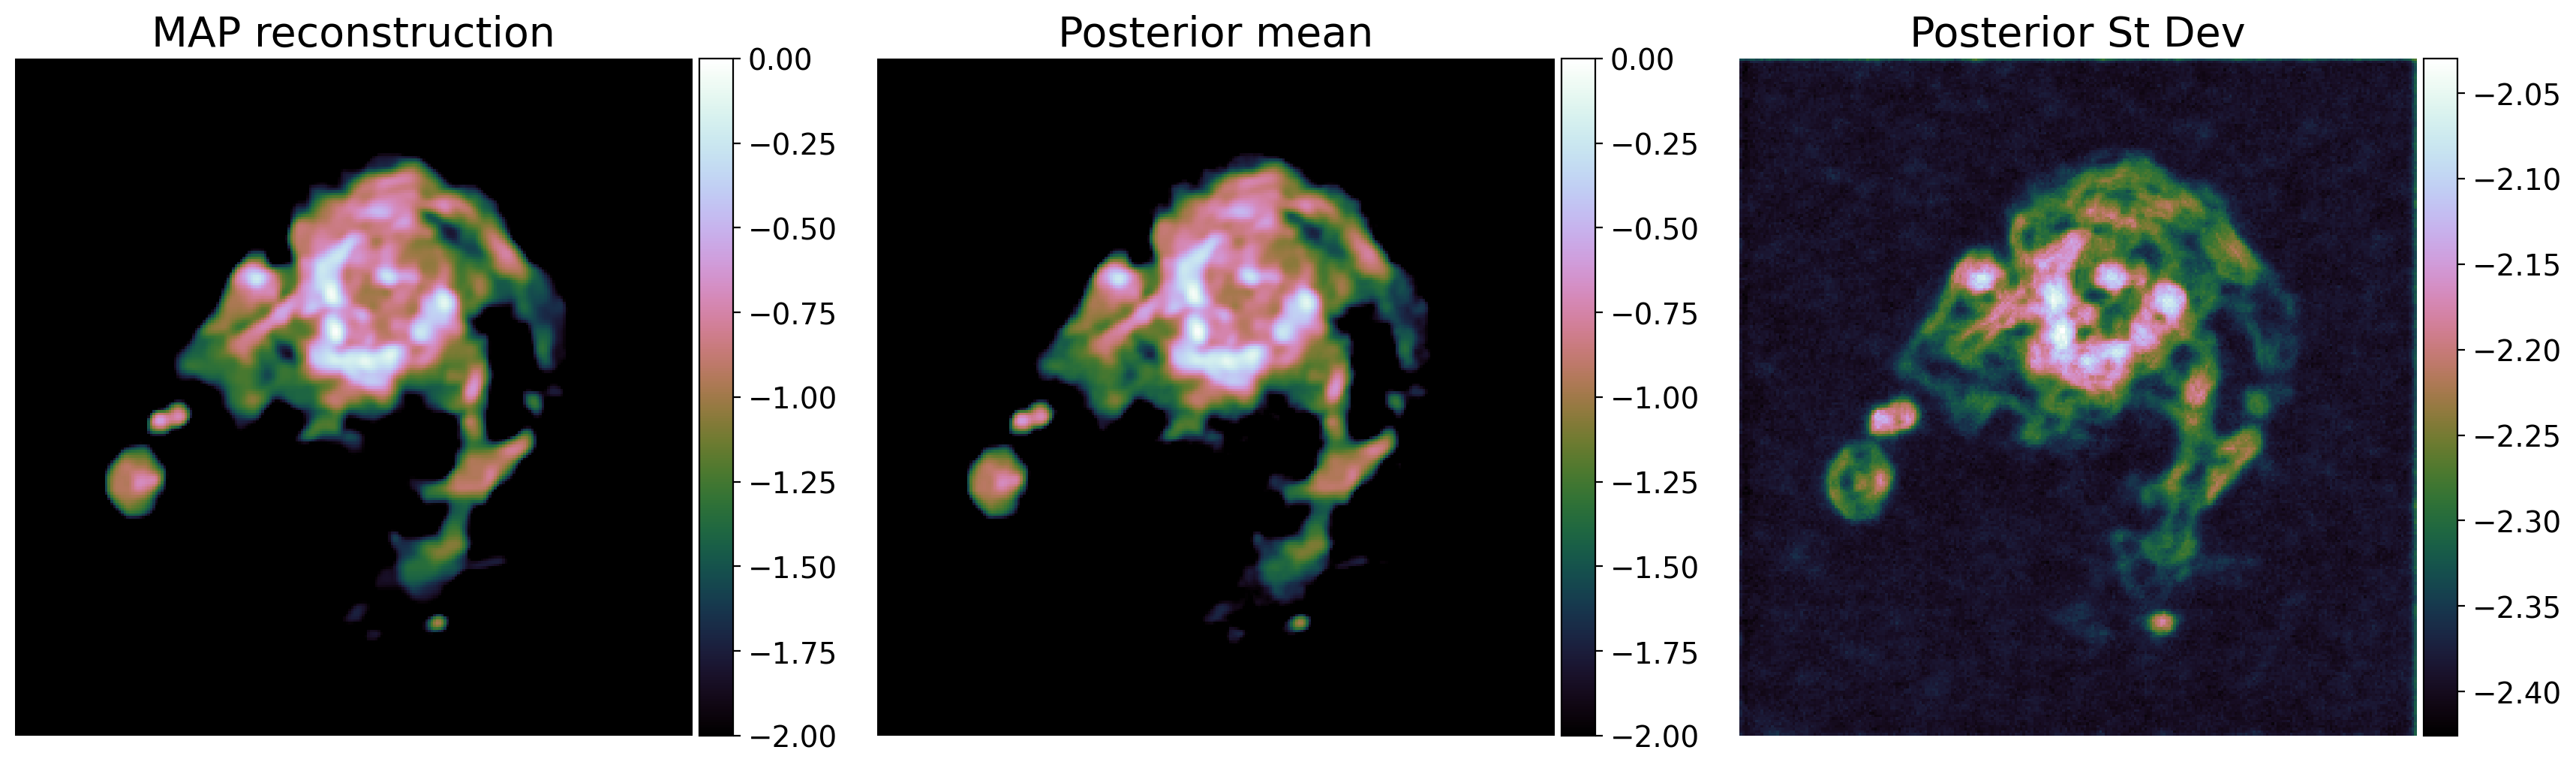

In [13]:
# Convert to numpy
np_current_mean = to_numpy(current_mean)
np_current_var = to_numpy(current_var)


images = [np_x_map, np_current_mean, np.sqrt(np.abs(np_current_var))]
labels = ["MAP reconstruction", "Posterior mean", "Posterior St Dev"]
vmin_log = [-2.0, -2.0]

cmap = "cubehelix"

fig, axs = plt.subplots(1, len(images), figsize=(21, 6), dpi=200)
for i in range(len(images)):
    if i <=1:
        im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap, vmax=0, vmin=vmin_log[i])
    else:
        im = axs[i].imshow(np.log10(np.abs(images[i])), cmap=cmap)
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    axs[i].set_title(labels[i], fontsize=20)
    axs[i].axis("off")

plt.show()

### Compute LCIs from the posterior samples 

In [14]:
# HPD region param
alpha_prob = 0.01
# For the sampling UQ plots
superpix_sizes = [16, 8, 4, 2]

quantiles, st_dev_down, means_list = qai.map_uncertainty.compute_UQ(
    MC_X, superpix_sizes, alpha_prob
)

### Plot LCIs, posterior mean and standard deviation with different superpixel sizes

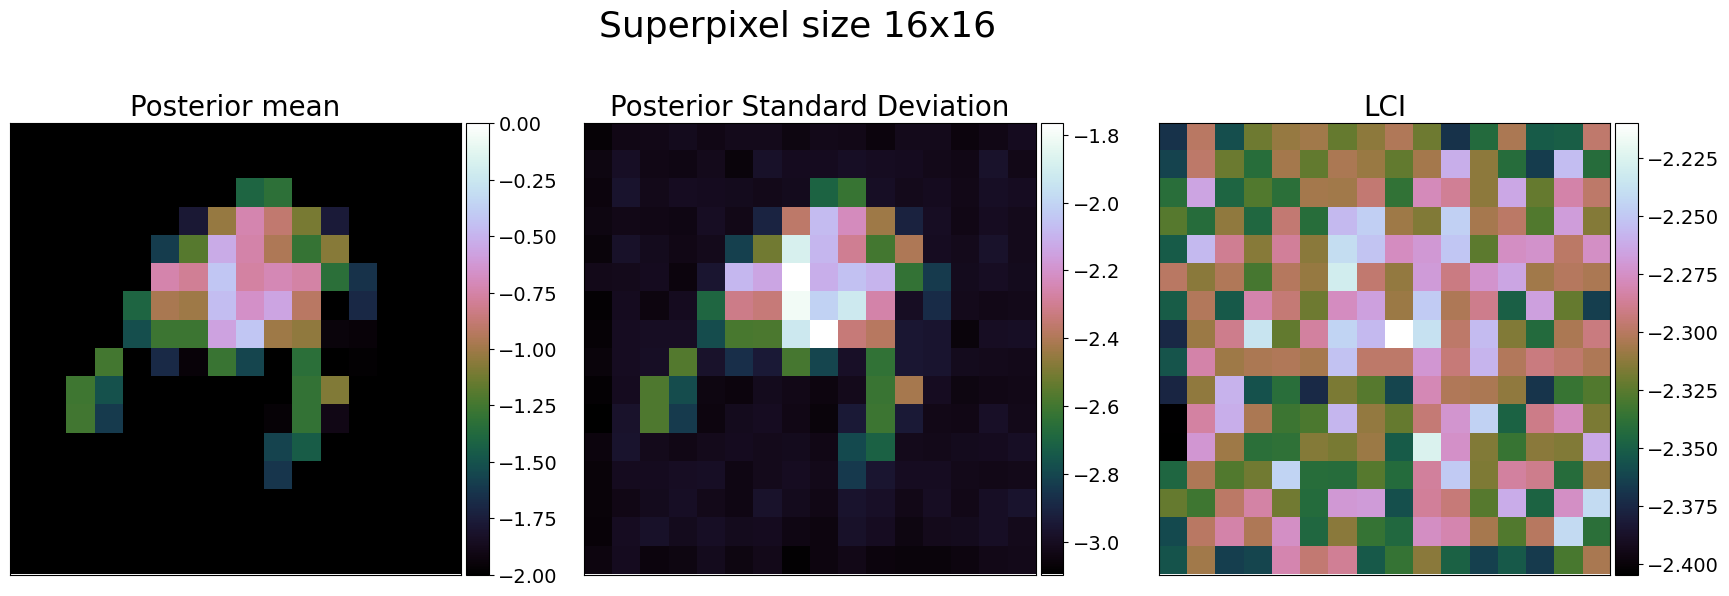

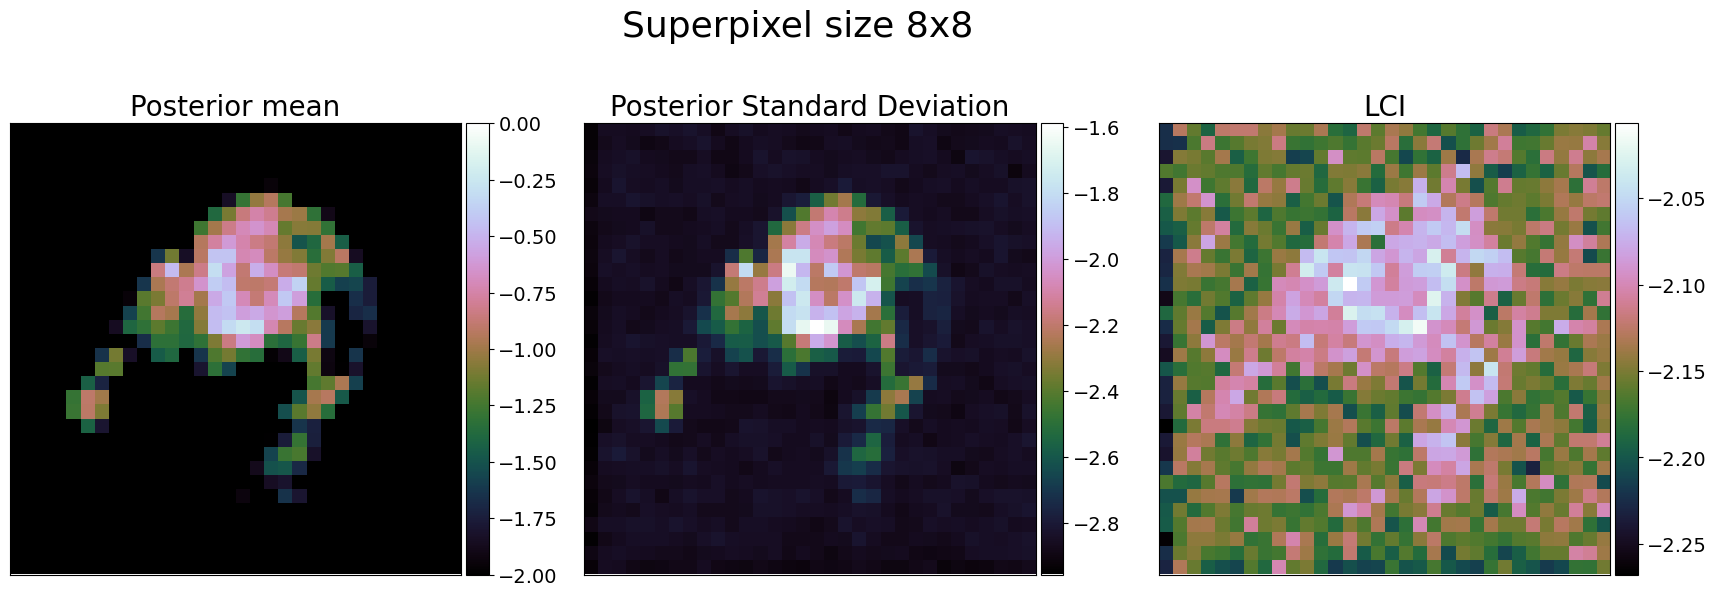

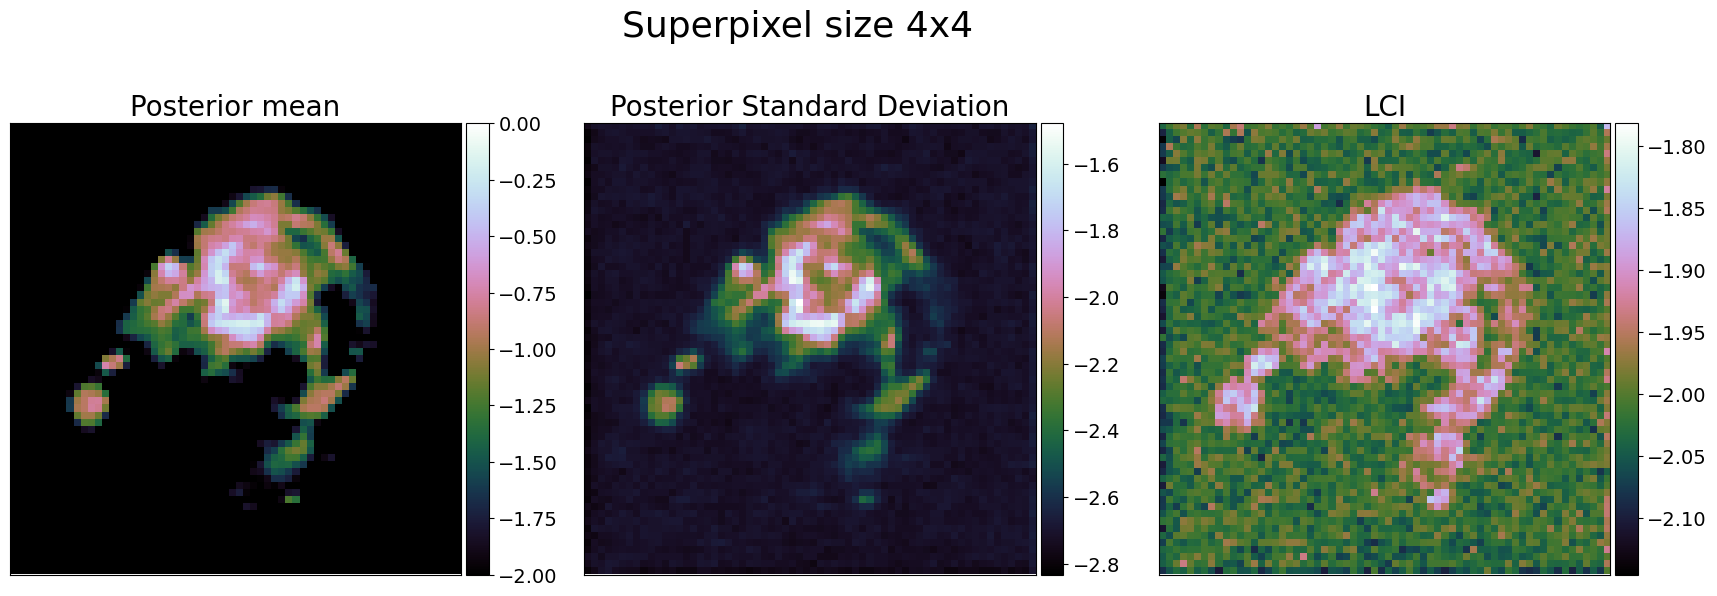

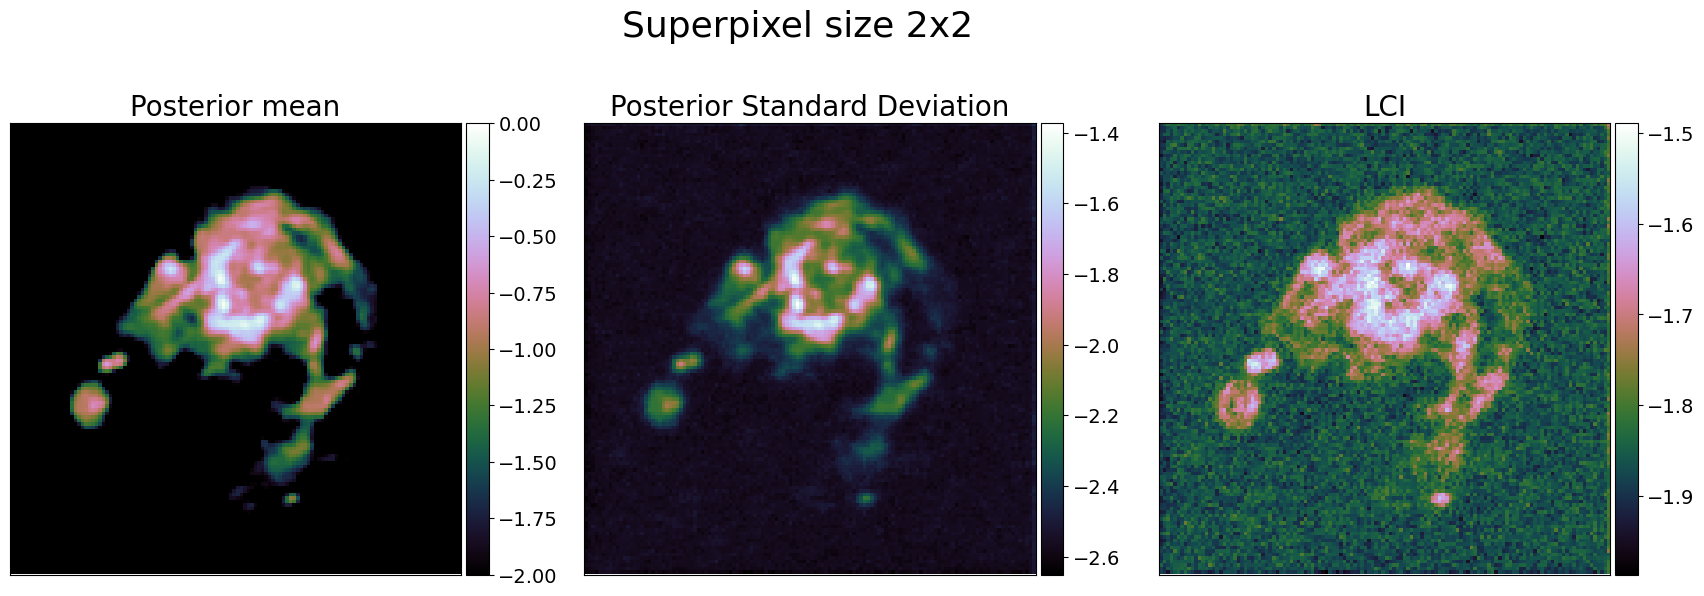

In [15]:
for it_4, pix_size in enumerate(superpix_sizes):
    # Plot UQ
    fig = plt.figure(figsize=(21, 7))

    plt.subplot(131)
    ax = plt.gca()
    ax.set_title(f"Posterior mean", fontsize=20)
    im = ax.imshow(np.log10(np.abs(means_list[it_4])), cmap=cmap, vmax=0, vmin=-2.)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    ax.set_yticks([])
    ax.set_xticks([])

    plt.subplot(132)
    ax = plt.gca()
    ax.set_title(f"Posterior Standard Deviation", fontsize=20)
    im = ax.imshow(np.log10(np.abs(st_dev_down[it_4])), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    ax.set_yticks([])
    ax.set_xticks([])

    plt.subplot(133)
    LCI = quantiles[it_4][1, :, :] - quantiles[it_4][0, :, :]
    ax = plt.gca()
    ax.set_title(f"LCI", fontsize=20)
    im = ax.imshow(np.log10(np.abs(LCI)), cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical")
    cbar.ax.tick_params(labelsize=14)
    ax.set_yticks([])
    ax.set_xticks([])

    fig.suptitle(f"Superpixel size {pix_size:d}x{pix_size:d}", fontsize=26)

    plt.show()
    